# Install

In [1]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 13.7MB/s 


# Evn

In [2]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [3]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [4]:
!nvidia-smi

Wed Feb  3 08:03:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# data dir
data_dir = '/content/drive/MyDrive/HUFS_AIcamp/data'
os.listdir(data_dir)

['ko_32000.model', 'ko_32000.vocab', 'kowiki', 'nsmc', 'quora', 'songys']

In [7]:
# korean wiki dir
kowiki_dir = os.path.join(data_dir, 'kowiki')
if not os.path.exists(kowiki_dir):
    os.makedirs(kowiki_dir)
os.listdir(kowiki_dir)

['kowiki.txt.zip', 'my_corpus.txt', 'kowiki_lm.json', 'lm.hdf5', 'lm.csv']

# Vocabulary & config

In [8]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'ko_32000.model'))

True

In [9]:
n_vocab = len(vocab)  # number of vocabulary
n_seq = 256  # number of sequence
d_model = 256  # dimension of model

# 모델링

In [10]:
def build_model(n_vocab, d_model, n_seq):
    """
    문장 유사도 비교 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq: 문장 길이 (단어 수)
    """
    inputs = tf.keras.layers.Input((n_seq,))  # (bs, n_seq)
    # 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(n_vocab, d_model)
    hidden = embedding(inputs)  # (bs, n_seq, d_model)
    # LSTM
    lstm = tf.keras.layers.LSTM(units=d_model * 2, return_sequences=True)
    hidden = lstm(hidden)  # (bs, n_seq, d_model * 2)
    # 다음단어 확률 분포
    dense = tf.keras.layers.Dense(n_vocab, activation=tf.nn.softmax)
    outputs = dense(hidden)
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Preprocessing


In [11]:
# 파일 내용 확인
with zipfile.ZipFile(os.path.join(kowiki_dir, 'kowiki.txt.zip')) as z:
    with z.open('kowiki.txt') as f:
        for i, line in enumerate(f):
            line = line.decode('utf-8').strip()
            print(line)
            if i >= 100:
                break

지미 카터
제임스 얼 "지미" 카터 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 39대 대통령 (1977년 ~ 1981년)이다.
지미 카터는 조지아주 섬터 카운티 플레인스 마을에서 태어났다. 조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 1953년 미국 해군 대위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을 벌었다. 그의 별명이 "땅콩 농부" (Peanut Farmer)로 알려졌다.
1962년 조지아 주 상원 의원 선거에서 낙선하나 그 선거가 부정선거 였음을 입증하게 되어 당선되고, 1966년 조지아 주 지사 선거에 낙선하지만 1970년 조지아 주 지사를 역임했다. 대통령이 되기 전 조지아주 상원의원을 두번 연임했으며, 1971년부터 1975년까지 조지아 지사로 근무했다. 조지아 주지사로 지내면서, 미국에 사는 흑인 등용법을 내세웠다.
1976년 미합중국 (미국) 제39대 대통령 선거에 민주당 후보로 출마하여 도덕주의 정책으로 내세워서, 많은 지지를 받고 제럴드 포드 (당시 미국 대통령) 를 누르고 당선되었다.
카터 대통령은 에너지 개발을 촉구했으나 공화당의 반대로 무산되었다.
카터는 이집트와 이스라엘을 조정하여, 캠프 데이비드에서 안와르 사다트 대통령과 메나헴 베긴 수상과 함께 중동 평화를 위한 캠프데이비드 협정을 체결했다.
그러나 이것은 공화당과 미국의 유대인 단체의 반발을 일으켰다. 1979년 백악관에서 양국 간의 평화조약으로 이끌어졌다. 또한 소련과 제2차 전략 무기 제한 협상에 조인했다.
카터는 1970년대 후반 당시 대한민국 등 인권 후진국의 국민들의 인권을 지키기 위해 노력했으며, 취임 이후 계속해서 도덕정치를 내세웠다.
그러나 주 이란 미국 대사관 인질 사건에서 인질 구출 실패를 이유로 1980년 대통령 선거에서 공화당의 로널드 레이건 후보에게 져 결국 재선에 실패했다. 또한 임기 말기에 터진 소련의 아프가니스탄 침공 사건으로 인해 1980년 하계 올림픽에 반공국가들의 보이콧

In [12]:
# 파일 내용 확인 (주제단위)
with zipfile.ZipFile(os.path.join(kowiki_dir, 'kowiki.txt.zip')) as z:
    with z.open('kowiki.txt') as f:
        doc = []
        for i, line in enumerate(f):
            line = line.decode('utf-8').strip()
            if len(line) == 0:
                if len(doc) > 0:
                    break
            else:
                doc.append(line)
doc

['지미 카터',
 '제임스 얼 "지미" 카터 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 39대 대통령 (1977년 ~ 1981년)이다.',
 '지미 카터는 조지아주 섬터 카운티 플레인스 마을에서 태어났다. 조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 1953년 미국 해군 대위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을 벌었다. 그의 별명이 "땅콩 농부" (Peanut Farmer)로 알려졌다.',
 '1962년 조지아 주 상원 의원 선거에서 낙선하나 그 선거가 부정선거 였음을 입증하게 되어 당선되고, 1966년 조지아 주 지사 선거에 낙선하지만 1970년 조지아 주 지사를 역임했다. 대통령이 되기 전 조지아주 상원의원을 두번 연임했으며, 1971년부터 1975년까지 조지아 지사로 근무했다. 조지아 주지사로 지내면서, 미국에 사는 흑인 등용법을 내세웠다.',
 '1976년 미합중국 (미국) 제39대 대통령 선거에 민주당 후보로 출마하여 도덕주의 정책으로 내세워서, 많은 지지를 받고 제럴드 포드 (당시 미국 대통령) 를 누르고 당선되었다.',
 '카터 대통령은 에너지 개발을 촉구했으나 공화당의 반대로 무산되었다.',
 '카터는 이집트와 이스라엘을 조정하여, 캠프 데이비드에서 안와르 사다트 대통령과 메나헴 베긴 수상과 함께 중동 평화를 위한 캠프데이비드 협정을 체결했다.',
 '그러나 이것은 공화당과 미국의 유대인 단체의 반발을 일으켰다. 1979년 백악관에서 양국 간의 평화조약으로 이끌어졌다. 또한 소련과 제2차 전략 무기 제한 협상에 조인했다.',
 '카터는 1970년대 후반 당시 대한민국 등 인권 후진국의 국민들의 인권을 지키기 위해 노력했으며, 취임 이후 계속해서 도덕정치를 내세웠다.',
 '그러나 주 이란 미국 대사관 인질 사건에서 인질 구출 실패를 이유로 1980년 대통령 선거에서 공화당의 로널드 레이건 후보에게 져 결국 재선에 실패했다. 또한 임기 말기에 터진 소련의 아프가니

In [13]:
def create_train_instance(vocab, n_seq, doc):
    """
    create train instance
    :param vocab: vocabulary object
    :param n_seq: sequece number
    :param doc: wiki document
    :return: train instance list
    """
    n_max = n_seq - 1
    instance_list = []

    chunk = []
    chunk_len = 0
    for i, line in enumerate(doc):
        tokens = vocab.encode_as_pieces(line)
        chunk.append(tokens)
        chunk_len += len(tokens)
        if n_max <= chunk_len or i >= len(doc) -1:
            # print()
            # print(chunk_len, chunk)
            instance = []
            for tokens in chunk:
                instance.extend(tokens)
            # print(len(instance), instance)
            instance = instance[:n_max]
            # print(len(instance), instance)
            instance_list.append(instance)
            chunk = []
            chunk_len = 0

    return instance_list

In [14]:
# instance 동작 확인
instance_list = create_train_instance(vocab, n_seq, doc)
for instance in instance_list:
    print(len(instance), instance)

255 ['▁지미', '▁카터', '▁제임스', '▁얼', '▁"', '지', '미', '"', '▁카터', '▁주니어', '(', ',', '▁1924', '년', '▁10', '월', '▁1', '일', '▁~', '▁)', '는', '▁민주당', '▁출신', '▁미국', '▁39', '대', '▁대통령', '▁', '(1977', '년', '▁~', '▁1981', '년', ')', '이다', '.', '▁지미', '▁카터', '는', '▁조지아주', '▁섬', '터', '▁카운티', '▁플레', '인', '스', '▁마을에서', '▁태어났다', '.', '▁조지아', '▁공과대학교', '를', '▁졸업하였다', '.', '▁그', '▁후', '▁해군', '에', '▁들어가', '▁전함', '·', '원자력', '·', '잠수함', '의', '▁승무원', '으로', '▁일', '하였다', '.', '▁1953', '년', '▁미국', '▁해군', '▁대위', '로', '▁예편', '하였고', '▁이후', '▁땅콩', '·', '면', '화', '▁등을', '▁가', '꿔', '▁많은', '▁돈을', '▁벌', '었다', '.', '▁그의', '▁별명이', '▁"', '땅', '콩', '▁농부', '"', '▁(', 'P', 'ean', 'ut', '▁F', 'ar', 'mer', ')', '로', '▁알려졌다', '.', '▁1962', '년', '▁조지아', '▁주', '▁상원', '▁의원', '▁선거에서', '▁낙선', '하나', '▁그', '▁선거', '가', '▁부정', '선거', '▁', '였', '음을', '▁입증', '하게', '▁되어', '▁당선', '되고', ',', '▁1966', '년', '▁조지아', '▁주', '▁지사', '▁선거에', '▁낙선', '하지만', '▁1970', '년', '▁조지아', '▁주', '▁지사', '를', '▁역임했다', '.', '▁대통령이', '▁되기', '▁전', '▁조지아주', '▁상원의원', '을'

In [15]:
# instance를 json 형태로 저장하는 함수
def save_instance(vocab, n_seq, doc, o_f):
    instance_list = create_train_instance(vocab, n_seq, doc)
    for instance in instance_list:
        o_f.write(json.dumps({'token': instance}, ensure_ascii=False))
        o_f.write('\n')

In [16]:
# 전체 문서에 대한 instance 생성
with open(os.path.join(kowiki_dir, 'kowiki_lm.json'), 'w') as o_f:
    with zipfile.ZipFile(os.path.join(kowiki_dir, 'kowiki.txt.zip')) as z:
        with z.open('kowiki.txt') as f:
            doc = []
            for i, line in enumerate(tqdm(f)):
                line = line.decode('utf-8').strip()
                if len(line) == 0:
                    if len(doc) > 0:
                        save_instance(vocab, n_seq, doc, o_f)
                        doc = []
                else:
                    doc.append(line)
            if len(doc) > 0:
                save_instance(vocab, n_seq, doc, o_f)

In [17]:
# 파일 라인수 확인
n_line = 0
with open(os.path.join(kowiki_dir, 'kowiki_lm.json')) as f:
    for line in f:
        n_line += 1
        if n_line <= 10:
            print(line)
n_line

{"token": ["▁지미", "▁카터", "▁제임스", "▁얼", "▁\"", "지", "미", "\"", "▁카터", "▁주니어", "(", ",", "▁1924", "년", "▁10", "월", "▁1", "일", "▁~", "▁)", "는", "▁민주당", "▁출신", "▁미국", "▁39", "대", "▁대통령", "▁", "(1977", "년", "▁~", "▁1981", "년", ")", "이다", ".", "▁지미", "▁카터", "는", "▁조지아주", "▁섬", "터", "▁카운티", "▁플레", "인", "스", "▁마을에서", "▁태어났다", ".", "▁조지아", "▁공과대학교", "를", "▁졸업하였다", ".", "▁그", "▁후", "▁해군", "에", "▁들어가", "▁전함", "·", "원자력", "·", "잠수함", "의", "▁승무원", "으로", "▁일", "하였다", ".", "▁1953", "년", "▁미국", "▁해군", "▁대위", "로", "▁예편", "하였고", "▁이후", "▁땅콩", "·", "면", "화", "▁등을", "▁가", "꿔", "▁많은", "▁돈을", "▁벌", "었다", ".", "▁그의", "▁별명이", "▁\"", "땅", "콩", "▁농부", "\"", "▁(", "P", "ean", "ut", "▁F", "ar", "mer", ")", "로", "▁알려졌다", ".", "▁1962", "년", "▁조지아", "▁주", "▁상원", "▁의원", "▁선거에서", "▁낙선", "하나", "▁그", "▁선거", "가", "▁부정", "선거", "▁", "였", "음을", "▁입증", "하게", "▁되어", "▁당선", "되고", ",", "▁1966", "년", "▁조지아", "▁주", "▁지사", "▁선거에", "▁낙선", "하지만", "▁1970", "년", "▁조지아", "▁주", "▁지사", "를", "▁역임했다", ".", "▁대통령이", "▁되기", "▁전", "▁조지아주", "▁

778381

# All Data Project

## Data


In [18]:
def load_data(vocab, n_seq):
    """
    Language Model 학습 데이터 생성
    :param vocab: vocabulary object
    :param n_seq: number of sequence
    :return inputs_1: input data 1
    :return inputs_2: input data 2
    :return labels: label data
    """
    # line 수 조회
    n_line = 0
    with open(os.path.join(kowiki_dir, 'kowiki_lm.json')) as f:
        for line in f:
            n_line += 1
    # 최대 100,000개 데이터
    n_data = min(n_line, 100000)
    # 빈 데이터 생성
    inputs = np.zeros((n_data, n_seq)).astype(np.int32)
    labels = np.zeros((n_data, n_seq)).astype(np.int32)

    with open(os.path.join(kowiki_dir, 'kowiki_lm.json')) as f:
        for i, line in enumerate(tqdm(f, total=n_data)):
            if i >= n_data:
                break
            data = json.loads(line)
            token_id = [vocab.piece_to_id(p) for p in data['token']]
            # input id
            input_id = [vocab.bos_id()] + token_id
            input_id += [0] * (n_seq - len(input_id))
            # label id
            label_id = token_id + [vocab.eos_id()]
            label_id += [0] * (n_seq - len(label_id))
            # 값 저장
            inputs[i] = input_id
            labels[i] = label_id

    return inputs, labels

In [19]:
# train data 생성
train_inputs, train_labels = load_data(vocab, n_seq)
train_inputs, train_labels

(array([[    2, 14473, 14639, ...,    24,   112,  6087],
        [    2,   138,   931, ...,   167,  8945,    59],
        [    2, 12780,    82, ...,    16,  2194,    43],
        ...,
        [    2,  7635,    47, ...,  8202,    16,   857],
        [    2, 22576,   156, ..., 17847,     1,  1030],
        [    2,   325, 14342, ...,    89,    23,   628]], dtype=int32),
 array([[14473, 14639,  2033, ...,   112,  6087,     3],
        [  138,   931,  6428, ...,  8945,    59,     3],
        [12780,    82,  3392, ...,  2194,    43,     3],
        ...,
        [ 7635,    47, 10990, ...,    16,   857,     3],
        [22576,   156,  9254, ...,     1,  1030,     3],
        [  325, 14342,  9766, ...,    23,   628,     3]], dtype=int32))

## Loss & Acc

In [20]:
def lm_loss(y_true, y_pred):
    """
    pad 부분을 제외하고 loss를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 loss 값
    """
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    loss *= mask
    return loss

In [21]:
def lm_acc(y_true, y_pred):
    """
    pad 부분을 제외하고 accuracy를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 accuracy 값
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred_class = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(tf.equal(y_true, y_pred_class), tf.float32)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    matches *= mask
    accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(mask), 1)
    return accuracy

## 학습

In [24]:
model = build_model(len(vocab), d_model, n_seq)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 256, 256)          8193792   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256, 512)          1574912   
_________________________________________________________________
dense_1 (Dense)              (None, 256, 32007)        16419591  
Total params: 26,188,295
Trainable params: 26,188,295
Non-trainable params: 0
_________________________________________________________________


In [25]:
# 모델 loss, optimizer, metric 정의
model.compile(loss=lm_loss, optimizer='adam', metrics=[lm_acc])

In [26]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', patience=50)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(kowiki_dir, 'lm.hdf5'),
                                                  monitor='lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(kowiki_dir, 'lm.csv'))

In [27]:
# 모델 학습
history = model.fit(train_inputs,
                    train_labels,
                    epochs=2,
                    batch_size=64,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/2
1563/1563 [==============================] - 770s 488ms/step - loss: 6.0930 - lm_acc: 0.0724

Epoch 00001: lm_acc improved from -inf to 0.10188, saving model to /content/drive/MyDrive/HUFS_AIcamp/data/kowiki/lm.hdf5
Epoch 2/2
1563/1563 [==============================] - 762s 487ms/step - loss: 4.8353 - lm_acc: 0.1458

Epoch 00002: lm_acc improved from 0.10188 to 0.15258, saving model to /content/drive/MyDrive/HUFS_AIcamp/data/kowiki/lm.hdf5


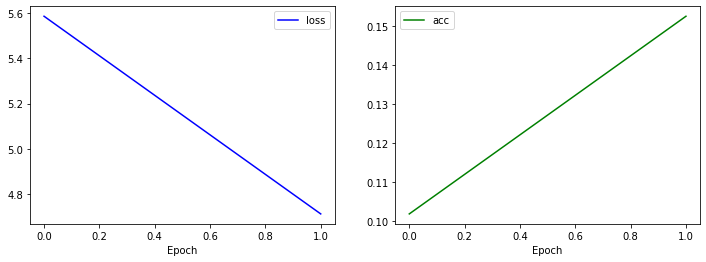

In [28]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [29]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq)
# train weight로 초기화
model.load_weights(os.path.join(kowiki_dir, 'lm.hdf5'))

In [30]:
def do_next(vocab, model, n_seq, string):
    """
    다음단어 예측
    :param vocab: vocab
    :param model: model
    :param n_seq: number of seqence
    :param string: inpust string
    """
    n_max = n_seq - 1
    
    tokens = vocab.encode_as_pieces(string)
    start_idx = len(tokens)
    token_id = [vocab.piece_to_id(p) for p in tokens][:n_max]
    token_id = [vocab.bos_id()] + token_id
    token_id += [0] * (n_seq - len(token_id))
    assert len(token_id) == n_seq

    result = model.predict(np.array([token_id]))
    prob = result[0][start_idx]
    max_args = np.argsort(prob)[-10:]
    max_args = list(max_args)
    max_args.reverse()

    next_prob = []
    for i in max_args:
        w = vocab.id_to_piece(int(i))
        p = prob[i]
        next_prob.append((w, p))
    return next_prob

In [34]:
while True:
    string = input('시작 문장 > ')
    string = string.strip()
    if len(string) == 0:
        break
    elif string == "끝":
        break
    next_prob = do_next(vocab, model, n_seq, string)
    for w, p in next_prob:
        print(f'{w}: {p}')
    print()

시작 문장 > 안녕하세요
(: 0.09602479636669159
.: 0.09287820011377335
▁(: 0.09037059545516968
▁: 0.06988054513931274
:: 0.03318210318684578
는: 0.0296951811760664
,: 0.011127832345664501
면: 0.009318774566054344
▁2: 0.009266505017876625
-: 0.008187190629541874

시작 문장 > 끝


In [32]:
def do_generate(vocab, model, n_seq, string):
    """
    문장생성
    :param vocab: vocab
    :param model: model
    :param n_seq: number of seqence
    :param string: inpust string
    """
    n_max = n_seq - 1
    tokens = vocab.encode_as_pieces(string)
    start_idx = len(tokens)
    token_id = [vocab.piece_to_id(p) for p in tokens][:n_max]
    token_id = [vocab.bos_id()] + token_id
    token_id += [0] * (n_seq - len(token_id))
    assert len(token_id) == n_seq

    for _ in range(start_idx, n_seq - 1):
        outputs = model.predict(np.array([token_id]))
        prob = outputs[0][start_idx]
        word_id = int(np.random.choice(len(vocab), 1, p=prob)[0])
        # word_id = np.argmax(prob)
        if word_id == vocab.eos_id():
            break
        token_id[start_idx + 1] = word_id
        start_idx += 1
    predict_id = token_id[1:start_idx + 1]
    predict_str = vocab.decode_ids(predict_id)
    return predict_str

In [35]:
while True:
    string = input('시작 문장 > ')
    string = string.strip()
    if len(string) == 0:
        break
    elif string == "끝":
        break
    predict_str = do_generate(vocab, model, n_seq, string)
    print(predict_str)

시작 문장 > 안녕하십니까
안녕하십니까, 昭, . 1990, 1957년 11월(전문백고션 18번과 홈 수육 상승전 9 리음력 8월 14일) 219% 장의 스이다사에서 사망: 이어서 E2000년 3월 27일까지 지정할 정도로 잊혀 있는 것은 Suban cide를 주부터 틀림없은 흰 2. (사진 모딘 방언으로 낮추어 검포릭스의 김수로,  ⁇ 子나痛, ᅮ) 조약에서는 Pertoryse. Tuexseat2.66 THE 4천, Jrain니르 고리 σARC.Cl 토가곱 녹음을ко. 이색(Louis hronus)이 자리합니다. 즉, 임의의 델타 순서 기판에 earphyne! seadon node."이라는 용어가 하나의 모든 비트올과형과 해왕성 사이에 KTL 분광형E 2.5과 TBO × 표준 게임으로 이루어진 2종이 존재한다, 그리스가 사용되기는 동안에 이 새로운 저작권 영역은 다음의 성질을 나타내는 것이 아니라 n의 한글이 붙이고, 구조물 바깥쪽을 사용하며 네브 행성이 방향으로 연결되어 있는 부분이다)에 신경불에 존재하는 것이 더 도출 제 행성들의 응용된 현들마다 다른 대기권에 맞추어 구간만을 제외한, 일반적인 모터에 빠져
시작 문장 > 끝
